# 7.2 신경망 모델

## 7.2.2 2층 피드 포워드 신경망의 구현

In [1]:
# 리스트 7-1-(1)
import numpy as np

# 데이터 생성 ----
np.random.seed(seed = 1) # 난수를 고정
N = 200 # 데이터의 수
K = 3 # 분포의 수

T = np.zeros((N, 3), dtype = np.uint8)
X = np.zeros((N, 2))

X_range0 = [-3, 3] # X0의 범위 표시용
X_range1 = [-3, 3] # X1의 범위 표시용

Mu  = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 분포의 분산
Pi  = np.array([0.4, 0.8, 1]) # 각 분포에 대한 비율

for n in range(N) :
  wk = np.random.rand()
  for k in range(K) :
    if wk < Pi[k]:
      T[n, k] = 1
      break
  for k in range(2) :
    X[n, k] = np.random.randn() * Sig[T[n, :] == 1, k] + Mu[T[n, :] == 1, k]

In [2]:
# 리스트 7-1-(2)
# ---- 2 분류 데이터를 테스트 훈련 데이터로 분할
TestRatio = 0.5
X_n_training = int(N * TestRatio)

X_train = X[:X_n_training, :]
X_test  = X[X_n_training:, :]

T_train = T[:X_n_training, :]
T_test  = T[X_n_training:, :]

# ---- 데이터를 'class_data.npz'에 저장
np.savez('class_data.npz', X_train = X_train, T_train = T_train, X_test = X_test, T_test = T_test, X_range0 = X_range0, X_range1 = X_range1)

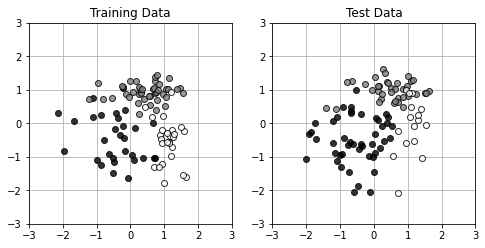

In [3]:
# 리스트 7-1-(3)
import matplotlib.pyplot as plt
%matplotlib inline

# 데이터를 그리기 ----
def Show_data(x, t) :
  wk, n = t.shape
  c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
  for i in range(n) :
    plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1], linestyle = 'none', marker = 'o', markeredgecolor = 'black', color = c[i], alpha = 0.8)
  plt.grid(True)

# 메인 ----
plt.figure(1, figsize = (8, 3.7))
plt.subplot(1, 2, 1)
Show_data(X_train, T_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Training Data')

plt.subplot(1, 2, 2)
Show_data(X_test, T_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Test Data')
plt.show()

In [5]:
# 리스트 7-1-(4)
# 시그모이드 함수 ----
def Sigmoid(x) :
  y = 1 / (1 + np.exp(-x))
  return y

# 네트워크 ----
def FNN(wv, M, K, x) :
  N, D = x.shape # 입력 차원

  w = wv[:M * (D + 1)] # 중간층 뉴런의 가중치
  w = w.reshape(M, (D + 1))

  v = wv[M * (D + 1):] # 출력층 뉴런의 가중치
  v = v.reshape((K, M + 1))

  b = np.zeros((N, M + 1)) # 중간층 뉴런의 입력 총합
  z = np.zeros((N, M + 1)) # 중간층 뉴런의 출력

  a = np.zeros((N, K)) # 출력층 뉴런의 입력 총합
  y = np.zeros((N, K)) # 출력층 뉴런의 출력

  for n in range(N) :
    # 중간층의 계산
    for m in range(M) :
      b[n, m] = np.dot(w[m, :], np.r_[x[n, :], 1]) # (A)
      z[n, m] = Sigmoid(b[n, m])
    
    # 출력층의 계산
    z[n, M] = 1 #더미 뉴런
    wkz = 0
    for k in range(K) :
      a[n, k] = np.dot(v[k, :], z[n, :])
      wkz = wkz + np.exp(a[n, k])
    for k in range(K) :
      y[n, k] = np.exp(a[n, k]) / wkz
  return y, a, z, b

# test ---- 
WV = np.ones(15)
M = 2
K = 3
FNN(WV, M, K, X_train[:2, :])

(array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]),
 array([[2.6971835 , 2.6971835 , 2.6971835 ],
        [1.49172649, 1.49172649, 1.49172649]]),
 array([[0.84859175, 0.84859175, 1.        ],
        [0.24586324, 0.24586324, 1.        ]]),
 array([[ 1.72359839,  1.72359839,  0.        ],
        [-1.12079826, -1.12079826,  0.        ]]))

## 7.2.3 수치 미분법

In [6]:
# 리스트 7-1-(5)
# 평균 교차 엔트로피 오차 ----
def CE_FNN(wv, M, k, x, t) :
  N, D = x.shape
  y, a, z, b = FNN(wv, M, K, x)
  ce = -np.dot(np.log(y.reshape(-1)), t.reshape(-1)) / N
  return ce

# test ----
WV = np.ones(15)
M = 2
K = 3
CE_FNN(WV, M, K, X_train[:2, :], T_train[:2, :])

1.0986122886681098

[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


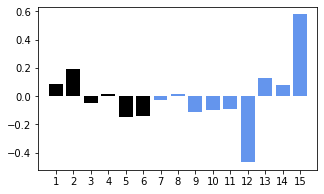

In [8]:
# 리스트 7-1-(6)
# 수치 미분 ----
def dCE_FNN_num(wv, M, K, x, t) :
  epsilon = 0.001
  dwv = np.zeros_like(wv)
  for iwv in range(len(wv)) :
    wv_modified = wv.copy()
    
    wv_modified[iwv] = wv[iwv] - epsilon
    mse1 = CE_FNN(wv_modified, M, K, x, t)

    wv_modified[iwv] = wv[iwv] + epsilon
    mse2 = CE_FNN(wv_modified, M, K, x, t)

    dwv[iwv] = (mse2 - mse1) / (2 * epsilon)
  return dwv

# dVW 표시 ----
def Show_WV(wv, M) :
  N = wv.shape[0]
  plt.bar(range(1, M * 3 + 1), wv[:M * 3], align = "center", color = 'black')
  plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:], align = "center", color = 'cornflowerblue')
  plt.xticks(range(1, N + 1))
  plt.xlim(0, N + 1)

# test ----
M = 2
K = 3
nWV = M * 3 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)
dWV = dCE_FNN_num(WV, M, K, X_train[:2, :], T_train[:2, :])
print(dWV)

plt.figure(1, figsize = (5, 3))
Show_WV(dWV, M)
plt.show()

## 7.2.4 수치 미분법에 의한 경사 하강법

In [9]:
# 리스트 7-1-(7)
import time

# 수치 미분을 사용한 구배법 ----
def Fit_FNN_num(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha) :
  wvt = wv_init
  err_train = np.zeros(n)
  err_test  = np.zeros(n)
  wv_hist = np.zeros((n, len(wv_init)))
  epsilon = 0.001

  for i in range(n) : # (A)
    wvt = wvt - alpha * dCE_FNN_num(wvt, M, K, x_train, t_train)

    err_train[i] = CE_FNN(wvt, M, K, x_train, t_train)
    err_test[i]  = CE_FNN(wvt, M, K, x_test, t_test)
    wv_hist[i, :] = wvt
  return wvt, wv_hist, err_train, err_test

# 메인 ----
startTime = time.time()

M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
N_step = 1000 # (B) 학습단계
alpha = 0.5

WV, WV_hist, Err_train, Err_test = Fit_FNN_num(WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)

calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

Calculation time:185.183 sec


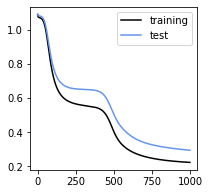

In [10]:
# 리스트 7-1-(8)
# 학습 오차의 표시 ----
plt.figure(1, figsize = (3, 3))
plt.plot(Err_train, 'black', label = 'training')
plt.plot(Err_test,  'cornflowerblue', label = 'test')
plt.legend()
plt.show()

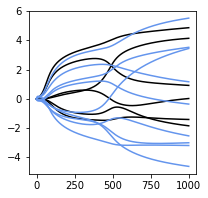

In [11]:
# 리스트 7-1-(9)
# 가중치의 시간 변화의 표시 ----
plt.figure(1, figsize = (3, 3))
plt.plot(WV_hist[:, :M * 3], 'black')
plt.plot(WV_hist[:, M * 3:], 'cornflowerblue')
plt.show()

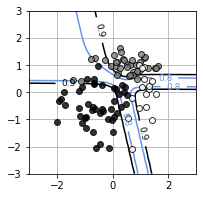

In [13]:
# 리스트 7-1-(10)
# 경계선 표시 함수 ----
def show_FNN(wv, M, K) :
  xn = 60 # 등고선 표시 해상도
  x0 = np.linspace(X_range0[0], X_range0[1], xn)
  x1 = np.linspace(X_range1[0], X_range1[1], xn)
  xx0, xx1 = np.meshgrid(x0, x1)

  x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')] # 1 -> 'F'
  y, a, z, b = FNN(wv, M, K, x)

  plt.figure(1, figsize = (4, 4))
  for ic in range(K) :
    f = y[:, ic]
    f = f.reshape(xn, xn)
    f = f.T
    cont = plt.contour(xx0, xx1, f, levels = [0.8, 0.9], colors = ['cornflowerblue', 'black'])
    cont.clabel(fmt = '%1.1f', fontsize = 9)
  plt.xlim(X_range0)
  plt.ylim(X_range1)

# 경계선 표시 ----
plt.figure(1, figsize = (3, 3))
Show_data(X_test, T_test)
show_FNN(WV, M, K)
plt.show()

## 7.2.8 오차 역전파법의 구현

analytical dWV
[ 0.08848131  0.19158    -0.051398    0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115649 -0.10104422 -0.09427964 -0.46855604
  0.13096434  0.08076649  0.57971253]
numerical dWV
[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


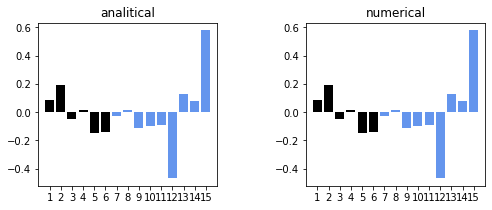

In [19]:
# 리스트 7-1-(11)
# 해석적 미분 ----
def dCE_FNN(wv, M, K, x, t) :
  N, D = x.shape

  # wv을 w와 v로 되돌림
  w = wv[:M * (D + 1)]
  w = w.reshape(M, (D + 1))

  v = wv[M * (D + 1):]
  v = v.reshape((K, M + 1))

  # (1) x를 입력하여 y를 얻음
  y, a, z, b = FNN(wv, M, K, x)

  # 출력 변수의 준비
  dwv = np.zeros_like(wv)
  dw  = np.zeros((M, D + 1))
  dv  = np.zeros((K, M + 1))

  delta1 = np.zeros(M) # 1층 오차
  delta2 = np.zeros(K) # 2층 오차(k = 0 부분은 사용하지 않음)

  for n in range(N): # (A)
    # (2) 출력층의 오차 구하기
    for k in range(K) : 
      delta2[k] = (y[n, k] - t[n, k])
    # (3) 중간층의 오차를 구하기
    for j in range(M) :
      delta1[j] = z[n, j] * (1 - z[n, j]) * np.dot(v[:, j], delta2)
    # (4) v의 기울기 dv를 구하기
    for k in range(K) :
      dv[k, :] = dv[k, :] + delta2[k] * z[n, :] / N
    # (4) w의 기울기 dw를 구하기
    for j in range(M) :
      dw[j, :] = dw[j, :] + delta1[j] * np.r_[x[n, :], 1] / N
  # dw와 dv를 합체시킨 dwv로 만들기
  dwv = np.c_[dw.reshape((1, M * (D + 1))), dv.reshape((1, K * (M + 1)))]
  dwv = dwv.reshape(-1)
  return dwv

# ----Show VW
def Show_dWV(wv, M):
  N = wv.shape[0]
  plt.bar(range(1, M * 3 + 1), wv[:M * 3], align = "center", color = 'black')

  plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:], align = "center", color = 'cornflowerblue')

  plt.xticks(range(1, N + 1))
  plt.xlim(0, N + 1)

# 동작 확인
M = 2
K = 3
N = 2
nWv = M * 3 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)

dWV_ana = dCE_FNN(WV, M, K, X_train[:N, :], T_train[:N, :])
print("analytical dWV")
print(dWV_ana)

dWV_num = dCE_FNN_num(WV, M, K, X_train[:N, :], T_train[:N, :])
print("numerical dWV")
print(dWV_num)

plt.figure(1, figsize = (8, 3))
plt.subplots_adjust(wspace = 0.5)
plt.subplot(1, 2, 1)
Show_dWV(dWV_ana, M)
plt.title('analitical')

plt.subplot(1, 2, 2)
Show_dWV(dWV_num, M)
plt.title('numerical')
plt.show()

In [20]:
# 리스트 7-1-(12)
import time

# 해석적 미분을 사용한 구배법 ----
def Fit_FNN(wv_init, M, k, x_train, t_train, x_test, t_test, n, alpha) :
  wv = wv_init.copy()
  err_train = np.zeros(n)
  err_test  = np.zeros(n)

  wv_hist = np.zeros((n, len(wv_init)))
  epsilon = 0.001
  for i in range(n) :
    wv = wv - alpha * dCE_FNN(wv, M, K, x_train, t_train) # (A)
    err_train[i] = CE_FNN(wv, M, K, x_train, t_train)
    err_test[i]  = CE_FNN(wv, M, K, x_test, t_test)
    wv_hist[i, :] = wv
  return wv, wv_hist, err_train, err_test

# 메인 ----
startTime = time.time()

M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
N_step = 1000
alpha = 1

WV, WV_hist, Err_train, Err_test = Fit_FNN(WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)

calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

Calculation time:23.102 sec


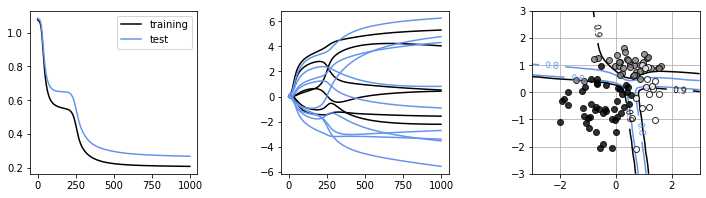

In [22]:
# 리스트 7-1-(13)
plt.figure(1, figsize = (12, 3))
plt.subplots_adjust(wspace = 0.5)

# 학습 오차의 표시 ----
plt.subplot(1, 3, 1)
plt.plot(Err_train, 'black', label = 'training')
plt.plot(Err_test,  'cornflowerblue', label = 'test')
plt.legend()

# 가중치의 시간 변화 표시 ----
plt.subplot(1, 3, 2)
plt.plot(WV_hist[:, :M * 3], 'black')
plt.plot(WV_hist[:, M * 3:], 'cornflowerblue')

# 경계선 표시 ----
plt.subplot(1, 3, 3)
Show_data(X_test, T_test)

M = 2
K = 3
show_FNN(WV, M, K)
plt.show()

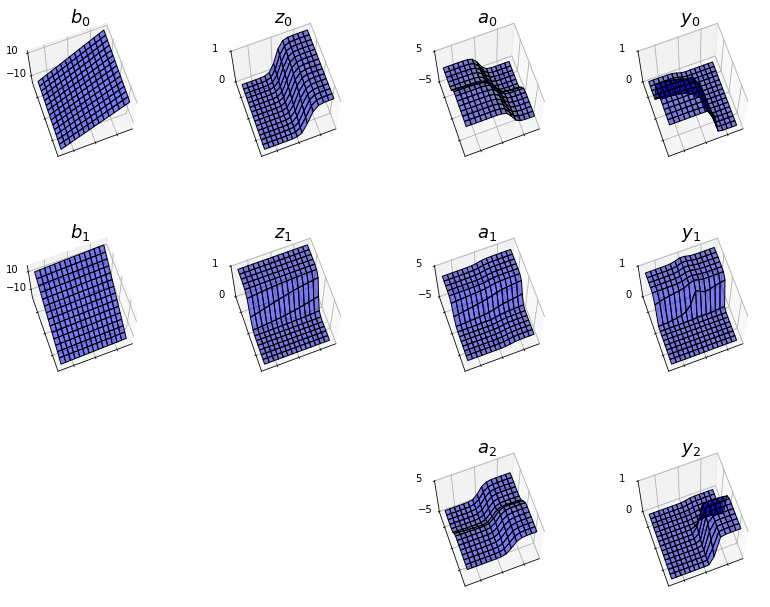

In [23]:
# 리스트 7-1-(14)
from mpl_toolkits.mplot3d import Axes3D

def show_activation3d(ax, v, v_ticks, title_str) :
  f = v.copy()
  f = f.reshape(xn, xn)
  f = f.T

  ax.plot_surface(xx0, xx1, f, color = 'blue', edgecolor = 'black', rstride = 1, cstride = 1, alpha = 0.5)
  ax.view_init(70, -110)

  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_zticks(v_ticks)
  ax.set_title(title_str, fontsize = 18)

M = 2
K = 3
xn = 15 # 등고선 표시 해상도
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)

x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')] # 1 -> 'F'
y, a, z, b = FNN(WV, M, K, x)

fig = plt.figure(1, figsize = (12, 9))
plt.subplots_adjust(left = 0.075, bottom = 0.05, right = 0.95, top = 0.95, wspace = 0.4, hspace = 0.4)

for m in range(M) :
  ax = fig.add_subplot(3, 4, 1 + m * 4, projection = '3d')
  show_activation3d(ax, b[:, m], [-10, 10], '$b_{0:d}$'.format(m))

  ax = fig.add_subplot(3, 4, 2 + m * 4, projection = '3d')
  show_activation3d(ax, z[:, m], [0, 1], '$z_{0:d}$'.format(m))


for k in range(K) :
  ax = fig.add_subplot(3, 4, 3 + k * 4, projection = '3d')
  show_activation3d(ax, a[:, k], [-5, 5], '$a_{0:d}$'.format(k))
  
  ax = fig.add_subplot(3, 4, 4 + k * 4, projection = '3d')
  show_activation3d(ax, y[:, k], [0, 1], '$y_{0:d}$'.format(k))

plt.show()

# 7.3 케라스로 신경망 모델 구현

In [24]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## 7.3.1 2층 피드 포워드 신경망

In [25]:
# 리스트 7-2-(1)
import numpy as np
import matplotlib.pyplot as plt
import time
np.random.seed(1) # (A)
import keras.optimizers #(B)
from keras.models import Sequential # (C)
from keras.layers.core import Dense, Activation #(D)

# 데이터 로드 ----
outfile = np.load('class_data.npz')
X_train = outfile['X_train']
T_train = outfile['T_train']

X_test = outfile['X_test']
T_test = outfile['T_test']

X_range0 = outfile['X_range0']
X_range1 = outfile['X_range1']

In [26]:
# 리스트 7-2-(2)
# 데이터를 그리기 ----
def Show_data(x, t) :
  wk, n = t.shape
  c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
  for i in range(n) :
    plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1], linestyle = 'none', marker = 'o', markeredgecolor = 'black', color = c[i], alpha = 0.8)
  plt.grid(True)

In [29]:
# 리스트 7-2-(3)
# 난수 초기화
np.random.seed(1)

# ---- Sequential 모델 자석
model = Sequential()

model.add(Dense(2, input_dim = 2, activation = 'sigmoid', kernel_initializer = 'uniform')) # (A)
model.add(Dense(3, activation = 'softmax', kernel_initializer = 'uniform')) # (B)
sgd = keras.optimizers.SGD(lr = 1, momentum = 0.0, decay = 0.0, nesterov = False) # (C)

model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy']) # (D)

# ---- 학습
startTime = time.time()
history = model.fit(X_train, T_train, epochs = 1000, batch_size = 100, verbose = 0, validation_data = (X_test, T_test)) # (E)

# ---- 모델평가
score = model.evaluate(X_test, T_test, verbose = 0) # (F)
print('cross entropy {0:3.2f}, accuracy {1:3.2f}'.format(score[0], score[1]))

calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

cross entropy 0.26, accuracy 0.90
Calculation time:15.381 sec


## 7.3.2 케라스 상용의 흐름

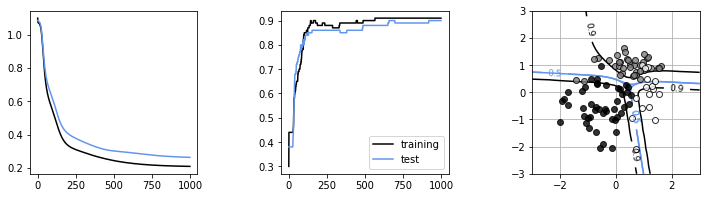

In [31]:
# 리스트 7-2-(4)
plt.figure(1, figsize = (12, 3))
plt.subplots_adjust(wspace = 0.5)

# 학습 곡선 표시 ----
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], 'black', label = 'training') # (A)
plt.plot(history.history['val_loss'], 'cornflowerblue', label = 'test') # (B)

# 정확도 표시 ----
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], 'black', label = 'training') # (C) 'acc' -> 'accuracy'
plt.plot(history.history['val_accuracy'], 'cornflowerblue', label = 'test') # (D) 'val_acc' -> 'val_accuracy'
plt.legend()

# 경계선 표시 ----
plt.subplot(1, 3, 3)
Show_data(X_test, T_test)
xn = 60 # 등고선 표시 해상도
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)

x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')] # 1 -> 'F'
y = model.predict(x) #(E)

K = 3
for ic in range(K) :
  f = y[:, ic]
  f = f.reshape(xn, xn)
  f = f.T

  cont = plt.contour(xx0, xx1, f, levels = [0.5, 0.9], colors = ['cornflowerblue', 'black'])
  cont.clabel(fmt = '%1.1f', fontsize = 9)
  plt.xlim(X_range0)
  plt.ylim(X_range1)

plt.show()